In [1]:
import numpy as np
import scipy.fftpack
from scipy import ndimage
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import os

In [2]:
data=pd.read_table('datos.txt')#Change01
nom_reg = '604'
nom_lin = 'Halpha'
pc=4.16 #If X and Y are in arcsec change for parsecs
#rs=0.01

In [3]:
#m=(data.X<145)&(data.X>60)#change to Headers name
#data=data[m]
data.describe()

,X,Y,RV
count,330.000000,330.000000,330.000000
mean,107.280000,9.390000,-275.757688
std,12.788265,6.260324,9.697986
min,85.824000,0.000000,-296.649181
25%,96.552000,4.000000,-282.613847
50%,107.280000,9.000000,-276.070115
75%,118.008000,15.000000,-270.394313
max,128.736000,19.600000,-231.143341


Bidimensional Data

(0.0, 33.0, 0.0, 10.0)

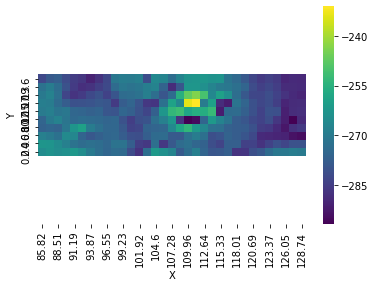

In [4]:
sig2=2*(data.RV.var())#Change to header
data_2=(data.round(2)).pivot(index='Y', columns='X', values='RV')#Change to header
sns.heatmap(data_2, cmap="viridis")
plt.gca().invert_yaxis()
plt.axis('equal')

Data Re arrange

In [5]:
df1=abs(data)
df1n=df1.to_numpy()

xl=[row[0] for row in df1n]
yl=[row[1] for row in df1n]
fl=[row[2] for row in df1n]

x1=[xl]
y1=[yl]
f1=[fl]

x=list(map(list, zip(*x1)))
y=list(map(list, zip(*y1)))
f=list(map(list, zip(*f1)))

Structure Function

In [6]:
fm=np.nanmean(f)
fv=np.nanvar(f,ddof=1)
fs=np.nanstd(f,ddof=1)
l=len(f)
S=[[fm],[fv],[fs],[l]]

In [7]:
a=[[0]*(l) for i in range(l)]
b=[[0]*(l) for i in range(l)]
c=[[0]*(2) for i in range(l*l)]

#Second Order Structure Function Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            a[i][j]=(((f[j][0])-(f[i][0]))**2)

#Normalized Second Order Structure Function Matrix [LxL]
#for i in range(l):
#    for j in range(l):
#        if i > j:
#            a[i][j]=(((f[j][0]-fm)-(f[i][0]-fm))**2)/(fv)

#Coord Matrix [LxL]
for i in range(l):
    for j in range(l):
        if i > j:
            b[i][j]=((x[i][0]-x[j][0])**2+(y[i][0]-y[j][0])**2)**0.5
            
#Main Matrix  [(L*L)x2]
for j in range (l):
    for i in range (l):
        c[i+j*(l)][1]=a[i][j]

for j in range (l):
    for i in range (l):
        c[i+j*(l)][0]=b[i][j]



In [8]:
#Filter: Greater than "0"
d=np.asarray(c)
ind=np.squeeze(d[:,1])>0.0
e=d[ind]
#Pandas Stuff
df=pd.DataFrame(e)
df.columns=['lag','qvd']#squared velocities difference
df.describe()

,lag,qvd
count,54206.000000,54206.000000
mean,17.756705,188.375987
std,9.502288,324.343415
min,1.341000,0.002087
25%,10.353411,16.902337
50%,16.458493,76.125205
75%,24.159951,223.129630
max,47.176263,4291.015099


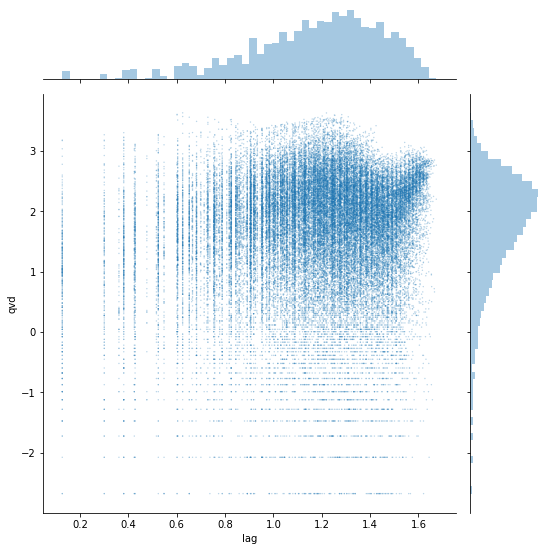

In [9]:
ax=sns.jointplot(x=np.log10(df.lag), y=np.log10(df.qvd), alpha=0.3, s=2, edgecolor='none')
ax.fig.set_size_inches(8,8)

In [10]:
#Main Filter
m=df.lag[1]-df.lag[0]#Lag step
n=int(df.lag.max()//df.lag.min())-1#Number of points
#Grouping points
dfx=dict()
for i in range(n):
    p=0+i*(m+0.001)
    q=m+i*m
    dfx[i]=df[df['lag'].between(p,q)]

In [11]:
dfx

{0:          lag        qvd
 0      1.341   0.169023
 329    1.341   0.676093
 983    1.341   2.556218
 2281   1.341  19.231104
 2602   1.341   7.263832
 ...      ...        ...
 54129  1.341  29.055326
 54162  1.341   2.005327
 54179  1.341  12.372093
 54196  1.341   6.312293
 54203  1.341   1.521210
 
 [159 rows x 2 columns], 1:             lag        qvd
 1      2.682000   0.169023
 32     2.300000   0.102249
 33     2.662383   0.408995
 360    2.662383   0.008347
 361    2.300000   0.052168
 ...         ...        ...
 54088  2.682000  85.991162
 54153  2.682000   0.920238
 54163  2.682000   0.300486
 54193  2.682000   0.408995
 54197  2.682000   9.934818
 
 [892 rows x 2 columns], 2:             lag        qvd
 34     3.533146   0.352654
 331    4.023000  23.005959
 363    3.533146  16.528816
 686    3.533146   0.534197
 690    3.533146  48.847754
 ...         ...        ...
 53713  4.023000  23.890723
 53884  4.023000  59.598475
 53999  4.023000   7.512150
 54164  4.023000  16.52

In [12]:
lgp=dict()
lpc=dict()
dl=dict()
dery=dict()
dfm=dict()
dfv=dict()
dfs=dict()
derx=dict()
dlm=dict()
dlv=dict()
dls=dict()

In [13]:

#Main Matrices Statistical Properties
for i in range(n):
    lgp[i]=(dfx[i]["lag"].max())
    lpc[i]=lgp[i]*pc
    dl[i]=len(dfx[i])#Numer of points each group
    #errorY
    dfm[i]=dfx[i]["qvd"].mean()
    dfv[i]=dfx[i]["qvd"].var()
    dfs[i]=dfx[i]["qvd"].std()
    if dl[i]>0:
        dery[i]=dfs[i]/np.sqrt(dl[i]-1)
    #errorX
    dlm[i]=dfx[i]["lag"].mean()
    dlv[i]=dfx[i]["lag"].var()
    dls[i]=dfx[i]["lag"].std()
    if dl[i]>0:
        derx[i]=dls[i]/np.sqrt(dl[i]-1)  


g=[[0]*(8) for i in range(n)]

for i in range(n):

    g[i][0]=lgp[i]
    g[i][1]=dfm[i]
    g[i][2]=dery[i]
    g[i][3]=dfs[i]
    g[i][4]=dfv[i]
    g[i][5]=lpc[i]
    g[i][6]=dl[i]
    g[i][7]=derx[i]


mx=[row[0] for row in g]
nx=[row[1] for row in g]
o=[row[2] for row in g]
mpc=[row[5] for row in g]

In [14]:
#Exponent

xa=[mx]
xe=list(map(list, zip(*xa)))
ya=[nx]
ye=list(map(list, zip(*ya)))

L=len(xe)

me=[[0]*(1) for i in range(L)]
ne=[[0]*(1) for i in range(L)]
oe=[[0]*(1) for i in range(L)]
pe=[[0]*(1) for i in range(L)]
qe=[[0]*(1) for i in range(L)]
re=[[0]*(1) for i in range(L)]
se=[[0]*(1) for i in range(L)]
te=[[0]*(1) for i in range(L)]
ue=[[0]*(1) for i in range(L)]
we=[[0]*(1) for i in range(L)]

for i in range (L):
    me[i][0]=math.log10(xe[i][0])
    ne[i][0]=math.log10(ye[i][0])
    oe[i][0]=(me[i][0]*ne[i][0])
    pe[i][0]=(me[i][0])**2

def sumColumn(a):
    return [sum(col) for col in zip(*a)]

for i in range (L+1):
    if i>0:
        qe[i-1]=sumColumn(me[:i])
        re[i-1]=sumColumn(ne[:i])
        se[i-1]=sumColumn(oe[:i])
        te[i-1]=sumColumn(pe[:i])
        ue[i-1][0]=len(x[:i])
    else:
        we[0][0]=0

for i in range (L):
    if i>0:
        we[i][0]=((qe[i][0]*re[i][0])-(ue[i][0]*se[i][0]))/((qe[i][0])**2-ue[i][0]*te[i][0])
    else:
        we[0][0]=0

In [15]:
A=[xe,ye,me,ne,oe,pe,qe,re,se,te,ue,we]
dfe=pd.DataFrame(A)
dfet=dfe.transpose()
dfet.columns=['Lag.x','Nmqvd.y','Logx','Logy','Logx*Logy','Logx^2','SumLogx','SumLogy','Sum','Sum','N','Exp']


In [16]:
exp=we
ft=np.append(g,we, axis=1)
sf=pd.DataFrame(ft)
sf.columns=['Lag','Nmqvd','ErrY','StD','Var','Lag pc','# P','ErrX','Exp']
sf.describe()

,Lag,Nmqvd,ErrY,StD,Var,Lag pc,# P,ErrX,Exp
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,3.400000e+01,34.000000
mean,23.421133,188.841425,8.974001,263.199497,77317.136292,97.431914,1422.941176,1.274768e-02,0.460713
std,13.336111,72.671826,6.932707,91.032376,50920.627055,55.478220,892.089510,1.042985e-02,0.213976
min,1.341000,46.732908,4.128951,134.549131,18103.468551,5.578560,40.000000,4.437333e-16,0.000000
25%,12.379457,124.950609,5.854590,204.308982,41742.923176,51.498539,721.500000,7.971937e-03,0.266087
50%,23.438313,187.329453,7.507278,243.513880,59317.454257,97.503382,1363.500000,9.569719e-03,0.485080
75%,34.493066,236.325412,8.689566,320.798320,102937.875219,143.491156,2256.750000,1.346081e-02,0.645931
max,45.557982,328.260478,43.096490,435.726503,189857.585102,189.521206,2851.000000,6.107829e-02,0.897413


In [17]:
sf

,Lag,Nmqvd,ErrY,StD,Var,Lag pc,# P,ErrX,Exp
0,1.341000,46.732908,12.422998,156.154666,24384.279850,5.578560,159.0,4.437333e-16,0.000000
1,2.682000,87.050459,7.644344,228.180793,52066.474158,11.157120,892.0,7.948313e-03,0.897413
2,4.023000,109.153166,10.173563,288.828861,83422.110789,16.735680,807.0,1.069205e-02,0.785647
3,5.364000,119.799502,7.804836,298.630605,89180.238405,22.314240,1465.0,8.496454e-03,0.693594
4,6.691225,133.404842,5.848795,268.917376,72316.554879,27.835497,2115.0,8.629103e-03,0.646101
5,8.000000,163.488407,7.545040,311.638487,97118.546404,33.280000,1707.0,8.059516e-03,0.653872
6,9.302284,180.962015,6.499610,311.913585,97290.084338,38.697503,2304.0,8.042809e-03,0.658534
7,10.664807,193.803396,6.402619,323.759899,104820.472179,44.365599,2558.0,6.732641e-03,0.656491
8,12.039810,205.016372,6.741360,352.940926,124567.297125,50.085610,2742.0,7.247399e-03,0.650834
9,13.398396,221.077370,7.248294,371.435265,137964.156270,55.737329,2627.0,7.896773e-03,0.648120


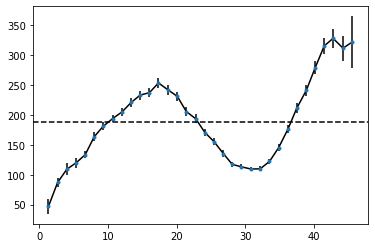

In [18]:
plt.plot(sf['Lag'],sf['Nmqvd'],color='k', alpha=1)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.axhline(y=sig2, color='k', linestyle='--')

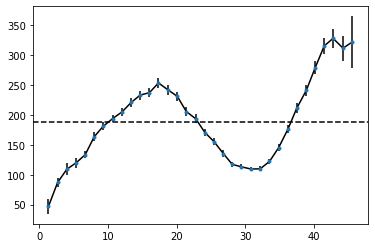

In [19]:
plt.plot(sf['Lag'],sf['Nmqvd'],color='k', alpha=1)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.axhline(y=sig2, color='k', linestyle='--')

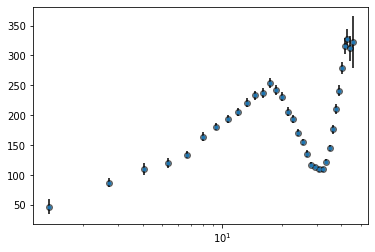

In [20]:
plt.scatter(sf['Lag'],sf['Nmqvd'],color='k', alpha=0.5)
plt.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k')
plt.xscale("log")

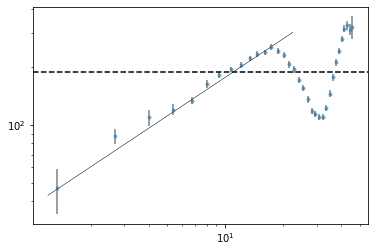

In [21]:
fig, ax=plt.subplots()
ax.errorbar(sf['Lag'],sf['Nmqvd'],xerr=sf.ErrX,yerr=sf.ErrY, fmt=".", ecolor='k', alpha=0.5)
ax.set(xscale='log',yscale='log')
ax.axhline(y=sig2, color='k', linestyle='--')
sgrid = np.logspace(.08, 1.35)
ax.plot(sgrid, 38.0*sgrid**(2/3), color="k", lw=0.5)

[(-310.0, -240.0)]

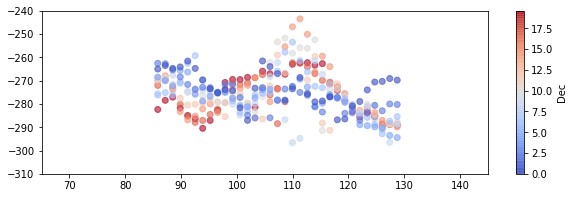

In [22]:
fig, ax = plt.subplots(figsize=(10, 3))
scat = plt.scatter(data.X, data.RV, c=data.Y, alpha=0.6, cmap="coolwarm")
fig.colorbar(scat, ax=ax).set_label("Dec")
ax.set(xlim=[65.0, 145.0])
ax.set(ylim=[-310.0, -240.0])